# week 10 - Information Theory

In [1]:
print("Hello, world!")

Hello, world!


In [2]:
import zlib # Also lzma

text = "Here is some text some text text text with repetition"
print(F"Original text {len(text)} bytes", text)

text_bytes = text.encode('ascii')
comp = zlib.compress(text_bytes)
print(f"Compressed text {len(comp)} bytes", comp)

decomp = zlib.decompress(comp)
print("Decompressed text", decomp.decode('ascii'))

ratio = len(comp) / len(text_bytes)
print(f"Compression ratio: {ratio:.2f}")

Original text 53 bytes Here is some text some text text text with repetition
Compressed text 43 bytes b'x\x9c\xf3H-JU\xc8,V(\xce\xcfMU(I\xad(Ab!\x88\xf2\xcc\x92\x0c\x85\xa2\xd4\x82\xd4\x92\xcc\x92\xcc\xfc<\x00\x0c\x82\x13\xfc'
Decompressed text Here is some text some text text text with repetition
Compression ratio: 0.81


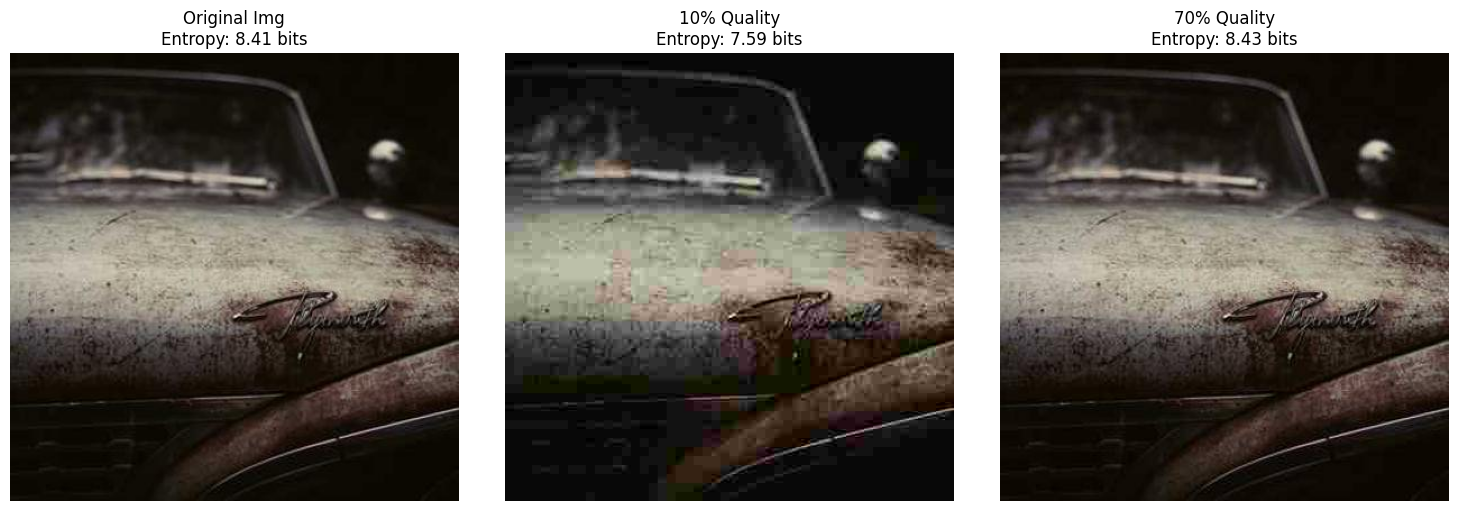

In [7]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def entropy(img):
    hist = img.histogram()
    probs = [float(h) / sum(hist) for h in hist]
    return -sum(p * np.log2(p) for p in probs if p != 0)

def compress(img, quality=75):
    fname = f'../images/q_{quality}.jpg'
    img.save(fname, 'JPEG', quality=quality)
    compressed = Image.open(fname)
    return compressed, entropy(compressed)

url = 'https://picsum.photos/400/400'
response = requests.get(url)
original = Image.open(BytesIO(response.content))

qualities = [10, 70]
images = [original]
entropies = [entropy(original)]
titles = ['Original Img']
for q in qualities:
    img_c, img_h = compress(original, q)
    images.append(img_c)
    entropies.append(img_h)
    titles.append(f'{q}% Quality')

plt.figure(figsize=(15, 5))
for lcv, (img, ent, title) in enumerate(zip(images, entropies, titles), start=1):
    plt.subplot(1, len(images), lcv)
    plt.imshow(img)
    plt.title(f'{title}\nEntropy: {ent:.2f} bits')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Week 11 - Network Simulation

In [4]:
%pip install faker tqdm
from tqdm import tqdm
from queue import Queue
from faker import Faker
from time import time, sleep


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
class Device:
    def __init__(self, name):
        self.ip = ""
        self.name = name
        self.inbox = Queue()

    def send(self, recip, msg):
        print(f"{self.name} is sending {len(msg)} bytes to {recip.ip}")
        for _ in tqdm(range(len(msg)), desc = "Sending", ncols = 100):
            sleep(0.25)
        recip.inbox.put(msg.encode('ascii'))
    
    def recieve(self):
        if not self.inbox.empty():
            msg = self.inbox.get().decode('ascii')
            print(f"{self.name} recieved a message: {msg}")
            return len(msg)
        return 0

In [6]:
class Network:
    def __init__(self):
        self.devices = []
        self.dhcp = Faker()
        self.start_time = time()
        self.usage = 0
        
    def add_device(self, device: Device):
        device.ip = self.dhcp.ipv4()
        self.devices.append(device)

    def sim_traffic(self):
        for device in self.devices:
            self.usage += device.recieve()

    def display(self):
        print(f"Uptime: {time() - self.start_time:.4} seconds")
        print(f"Data usage: {self.usage} bytes")
        print("Connected devices:")
        for d in self.devices:
            print(f"{d.name} \t\t {d.ip}")

In [8]:
alice = Device("Alice")
bob = Device("Bob")

network = Network()
network.add_device(alice)
network.add_device(bob)
network.display()

while True:
    sender_name = input("Who are you (Alice/Bob)?")
    if sender_name == "Alice":
        sender, recip = alice, bob
    elif sender_name == "Bob":
        sender, recip = bob, alice
    else:
        print("Invalid name")
        continue

    msg = input("Enter your message: ")
    sender.send(recip, msg)
    network.sim_traffic()

    loop = input("Do you want to send another message (y/n): ")
    if loop not in "yes":
        break


Uptime: 0.01081 seconds
Data usage: 0 bytes
Connected devices:
Alice 		 146.49.169.84
Bob 		 147.149.220.120
Bob is sending 14 bytes to 146.49.169.84


Sending: 100%|██████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.98it/s]


Alice recieved a message: my name is bob
Invalid name
Invalid name
Invalid name
Invalid name
Bob is sending 9 bytes to 146.49.169.84


Sending: 100%|████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.99it/s]


Alice recieved a message: bye alice


# Week 12 - TCP-IP Model

In [1]:
%pip install faker tqdm termcolor -q
import random
from tqdm import tqdm
from time import sleep
from faker import Faker
from termcolor import colored


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
def print_sleep(msg, seconds=1):
    print(msg)
    sleep(seconds)

def do_progress(length, desc, seconds=0.05):
    for _ in tqdm(range(length), desc=desc, mcols = 100):
        sleep(seconds)

In [ ]:
class ApplicationLayer:
    def __init__(self, data):
        self.data = data

    def prepare_data(self):
        print_sleep(colored("Application Layer: ", "cyan") + f"Preparing data '{self.data}'")
        return self.data.encode()
class TransportLayer:
    def __init__(self, protocol="TCP", port=80):
        self.protocol = protocol
        self.port = port
        self.sequence_number = random.randint(1, 1000)

    def prepare_segment(self, data):
        header = colored("Transport Layer: ", "magenta")
        if self.protocol == "TCP":
            print_sleep(header + f"Using TCP on Port {self.port} - Establishing connection...")
            print_sleep(header + f"SYN packet (Seq={self.sequence_number})", 0.5)
            print_sleep(header + f"SYN-ACK packet (Seq={self.sequence_number+1})", 0.5)
            print_sleep(header + f"ACK packet - Connection established!", 0.5)
        else:
            print(header + f"Using UDP on Port {self.port} - No connection setup required.")
        
        segment = f"{self.protocol}-Port-{self.port}-Segment-{self.sequence_number}|{data.decode()}"
        do_progress(len(segment), "Transport Layer Processing")
        return segment.encode()